# Problem Set 2, due April 27th at 3:30 pm

**Please Note:** This assignment will likely take you a _long_ time, especially if you are new to Python. Start early!

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on Canvas). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from Canvas. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|---------|---------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 'pobre'|
|progresa |treatment = 'basal'|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	  |gender of head of household (male=1)|
|hohage   |age of head of household|
|age      |years old|
|folnum	  |individual id|
|village  |	village id|
|sc97	  |schooling in 1997|

In [84]:
#import necessary libraries
import sys; print(sys.version)
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf

3.5.2 |Continuum Analytics, Inc.| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


In [2]:
#load the data
data = pd.read_csv('progresa_sample.csv')

In [3]:
#check the dimensions 
print(data.shape)

#print column names
print(data.columns)

(77250, 21)
Index(['year', 'sex', 'indig', 'dist_sec', 'sc', 'grc', 'fam_n', 'min_dist',
       'dist_cap', 'poor', 'progresa', 'hohedu', 'hohwag', 'welfare_index',
       'hohsex', 'hohage', 'age', 'village', 'folnum', 'grc97', 'sc97'],
      dtype='object')


---
##Part 1: Descriptive analysis

### 1.1	Summary Statistics

a) Present number of missing observations for every single variable


In [4]:
#check the number of missing values for each variable in the dataset
a = (pd.isnull(data)).sum()
print("Number of missing values ... ")
(pd.isnull(data)).sum()

Number of missing values ... 


year                0
sex                24
indig             300
dist_sec            0
sc               8453
grc              6549
fam_n               0
min_dist            0
dist_cap            0
poor                0
progresa            0
hohedu              0
hohwag              0
welfare_index     210
hohsex             20
hohage             10
age                 0
village             0
folnum              0
grc97               0
sc97             3872
dtype: int64

b) Present summary statistics (mean and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

In [6]:
sum_stat = data.describe()
sum_stat.columns

C:\Miniconda3\lib\site-packages\numpy\lib\function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Index(['year', 'sex', 'indig', 'dist_sec', 'sc', 'grc', 'fam_n', 'min_dist',
       'dist_cap', 'hohedu', 'hohwag', 'welfare_index', 'hohsex', 'hohage',
       'age', 'village', 'folnum', 'grc97', 'sc97'],
      dtype='object')

In [7]:
#select rows by labels and select required columns and then transpose it
sum_stat.ix[['mean','std'],['sex', 'indig', 'dist_sec', 'sc', 'grc', 'fam_n', 'min_dist',
       'dist_cap', 'hohedu', 'hohwag', 'welfare_index', 'hohsex', 'hohage',
       'age', 'grc97', 'sc97']].T

,mean,std
sex,0.512211,0.499854
indig,0.298324,0.457525
dist_sec,2.418910,2.234109
sc,0.819818,0.384342
grc,3.963537,2.499063
fam_n,7.215715,2.352900
min_dist,103.447520,42.089441
dist_cap,147.674452,76.063134
hohedu,2.768104,2.656106
hohwag,586.985312,788.133664


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages? Hint: Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 for individuals who are poor (i.e., poor=='pobre').

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male  |?     |?     |?     |?     |


In [28]:
def performttest(df,subvar,cols):
    """
    df:  pandas Dataframe
    subvar: the variable basis on which 2 groups will be created
    cols: variables of the dataframe to test
    ----------------------------------------------------------------------------------------------------------------------
    This function returns a pandas dataframe that will contain the means of all variables mentioned in the cols series. The 
    groups for the variable is created based on the subvar provided
    """
    #test
    #df= data
    #subvar = 'progresa'
    #cols = cols
    
    #get the unique values of the variable 
    uni_values = df[subvar].unique()
    
    #determine two subset groups 
    #control group uni_values[0] = 0
    group1 = df.loc[df[subvar] == uni_values[0],cols]
    #treatment group uni_values[0] = 'basal'
    group2 = df.loc[df[subvar] == uni_values[1],cols]
    
    #compute the mean for each of the group and variable
    g1_mean = group1.mean()
    g2_mean = group2.mean()
    
    #reset the index
    g1_mean.reset_index(drop=True, inplace = True)
    g2_mean.reset_index(drop=True, inplace = True)
    
    #compute the difference (Treatment - control)
    g_mean_diff = g2_mean - g1_mean
    
    #perform t-tests and save the results
    ttresults = stats.ttest_ind(group1.dropna(),group2.dropna())
    
    #capture p-values
    ttpval = ttresults.pvalue
    
    #convert to series
    ttpval = pd.Series(ttpval)
    
    #create a dataframe . Bind all the columns
    ttdf = pd.concat([pd.Series(cols),g2_mean,g1_mean,g_mean_diff,ttpval],axis=1)   
    
    #define column names
    ttdf.columns = ['variable name','treatment-mean','control-mean','Difference', 'p-value']
    
    #return dataframe
    return ttdf
    

In [136]:
#define columns
cols = ['dist_sec', 'sc', 'grc', 'fam_n', 'min_dist', 'sex', 'indig','sc97',
       'dist_cap', 'hohedu', 'hohwag', 'welfare_index','hohage', 'age',  'grc97']


#store the results
q1_2 = performttest(data.loc[((data.year==97) & (data.poor == 'pobre')),],'progresa',cols)

#print results
print(q1_2)

    variable name  treatment-mean  control-mean  Difference       p-value
0        dist_sec        2.453122      2.507662   -0.054540  9.820915e-01
1              sc        0.822697      0.815186    0.007511  9.410266e-02
2             grc        3.531599      3.543050   -0.011450  3.999990e-01
3           fam_n        7.281327      7.302469   -0.021142  4.312448e-01
4        min_dist      107.152915    103.237854    3.915060  2.471868e-18
5             sex        0.519317      0.505052    0.014265  1.913967e-02
6           indig        0.325986      0.332207   -0.006222  1.246761e-01
7            sc97        0.822697      0.815186    0.007511  9.410266e-02
8        dist_cap      150.829074    153.769730   -2.940656  3.372619e-03
9          hohedu        2.663139      2.590348    0.072791  2.598679e-02
10         hohwag      544.339544    573.163558  -28.824015  2.688555e-04
11  welfare_index      655.428377    659.579100   -4.150723  4.083306e-04
12         hohage       43.648828     

### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

- A. We observe that there are very few p-values less than 0.05, which implies there is no statistical differences between treatement and control villages at baseline.
- B. If there were differences it would mean that the groups were not randomly choosen. This could effect our study where we are trying to find if treatment is the reason for the increase in the enrollment rates.
- C. Since there are no signicant differences in the means of the two sample group, we can measure the effect of the treatment as the only effect on enrollment rates.

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average enrollment rate in 1997. Create a scatterplot that shows this relationship. What do you notice?

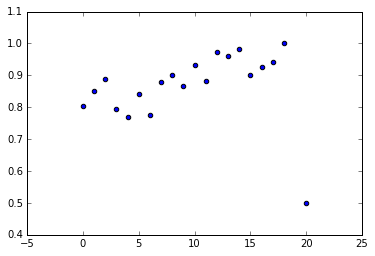

In [18]:
plt.scatter(data.hohedu.unique(),data[(data.year==97)].groupby('hohedu')['sc'].mean())

There is an steady increase in the average enrollment with an increase in the grade of head of household, but we observe a phenomenal dip in the grade 20

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households).
* Does there appear to be a difference? Is this difference statistically significant?
* Which D estimator in Schultz (2004) does this approach correspond to?

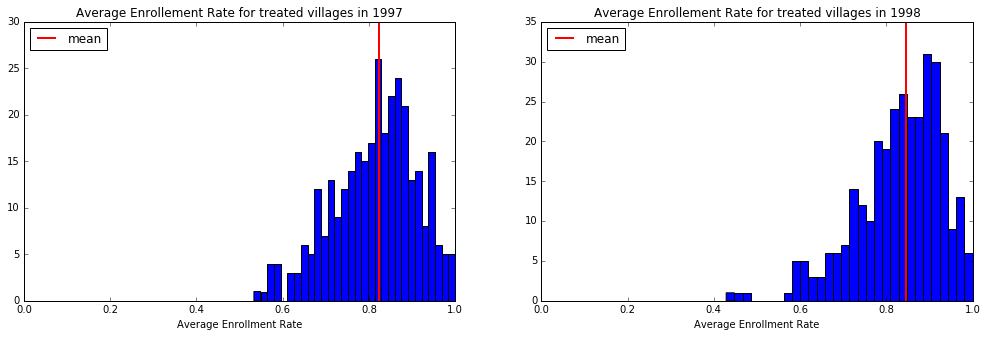

In [101]:
#define the plot area size. 
plt.figure(figsize=(17, 5))

#divide the plot into 1 row and 2 columns. Plot the first histogram in the first subplot.
plt.subplot(1,2,1)
plt.title("Average Enrollement Rate for treated villages in 1997")
plt.xlabel("Average Enrollment Rate")
plt.xlim(0,1)

#calculate average enrollment rate of poor villages household in 1997  under treatment
plt.hist((data[((data.year==97)&(data.poor =='pobre')&(data.progresa == 'basal'))].groupby('village')['sc'].mean()), bins = 30)
#plot the overall average enrollment rate of por villages households in 1997 under treatment
plt.axvline(x = data[((data.year==97)&(data.poor =='pobre')&(data.progresa == 'basal'))].sc.mean(),color = 'r'
            , linewidth = 2, label = "mean")
#plot legend
plt.legend(loc= "upper left")


#Plot the second histogram in the seecond subplot.
plt.subplot(1,2,2)
plt.title("Average Enrollement Rate for treated villages in 1998")
plt.xlabel("Average Enrollment Rate")
plt.xlim(0,1)

#calculate average enrollment rate of poor villages household in 1998  under treatment
plt.hist((data[((data.year==98)&(data.poor =='pobre')&(data.progresa == 'basal'))].groupby('village')['sc'].mean()), bins = 30)
#plot the overall average enrollment rate of por villages households in 1998 under treatment
plt.axvline(x = data[((data.year==98)&(data.poor =='pobre')&(data.progresa == 'basal'))].sc.mean(), color = 'r'
            , linewidth= 2, label = "mean")
#plot legend
plt.legend(loc= "upper left")

In [32]:
#conduct t-test
stats.ttest_ind((data[((data.year==97)&(data.poor =='pobre')&(data.progresa == 'basal'))].groupby('village')['sc'].mean()),
                 (data[((data.year==98)&(data.poor =='pobre')&(data.progresa == 'basal'))].groupby('village')['sc'].mean()))


Ttest_indResult(statistic=-2.0157134865156379, pvalue=0.04424870036572115)

- There is a difference in the average enrollment rate in treated villages in 1997 and 1998. There appears to be shift towards right in the average enrollment rate in 1998. 
- Since the p-value is less that 0.05, the differences between the means are statistically significant.
- This approach corresponds to Shultz's D1 estimator.

## Part 2: Measuring Impact

### 2.1 Simple differences: T-test

Start out by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment).
* calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages.
* Which difference estimator in Schultz (2004) does this approach correspond to?
* Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [106]:
#subset treatment data
tm = data[((data.poor == 'pobre') & (data.progresa =='basal') & (data.year == 98))]

#print the average enrollment rate 
print('The average enrollment rate among poor households in the treatment vilages is %f' % tm.sc.mean())

#subset control data
ct = data[((data.poor == 'pobre') & (data.progresa =='0') & (data.year == 98))]

#print the average enrollment rate 
print('The average enrollment rate among poor households in the control vilages is %f' % ct.sc.mean())

#conduct t-test
tt_98 = stats.ttest_ind(tm.sc.dropna(),ct.sc.dropna())

#showcase t-test
print(tt_98)

The average enrollment rate among poor households in the treatment vilages is 0.846479
The average enrollment rate among poor households in the control vilages is 0.807637
Ttest_indResult(statistic=8.3587205674183735, pvalue=6.636344447523235e-17)


- This approach corresponds to Schultz's D2 estimator.
- Since the p-value is less than 0.05 which implies that the difference is statistically significant between the treatment and control group after Progresa treatment took place.

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

In [107]:
#drop nas
d = data.dropna()

#create dummy for progresa variable
X = pd.get_dummies(d[((d.poor == 'pobre') & (d.year == 98) )].progresa.dropna())

#store our target variable
y = d[(d.poor == 'pobre') & (d.year == 98)].sc

#merge them
modData = X.join(y)

#perform linear regression
linRegm = smf.ols(formula = 'sc ~ basal',data=modData).fit()

#print the summary
linRegm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     65.64
Date:                Mon, 01 May 2017   Prob (F-statistic):           5.66e-16
Time:                        20:35:43   Log-Likelihood:                -11171.
No. Observations:               26155   AIC:                         2.235e+04
Df Residuals:                   26153   BIC:                         2.236e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8109      0.004    217.190      0.000       0.804       0.818
basal          0.0383      0.005      8.102      0.000       0.029       0.048
==============================================================================
Omnibus:                     7487.800   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15756.374
Skew:                          -1.796   Prob(JB):                         0.00
Kurtosis:                       4.245   Cond. No.                         3.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Progresa increased the likelihood of a child enrolling by 0.0383

- The simple difference basically calculated the differences between the means of the treatment and control group after Progresa. Here we are estimating the effect of Progresa on each child and the assiociated likelihood of enrolling after Progresa.

- Since the p-value is less than 0.05, we can reject the null hypothesis which states that the treatment had no effect on the enrollment of rate after progresa

- The counterfactual assumption is if the treatment was not provided then the enrollment in the treatment and control group would remain same.

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [137]:
#subset the data
d = data.loc[((data.poor == 'pobre') & (data.year == 98)), ]

#create dummy for progresa
x1 = pd.get_dummies(d.progresa)

#join the progresa
X = d.join(x1)

#remove control dummy
X.drop(['progresa','0'],axis =1,inplace=True)

#run multiple linear regression
MlinRegm = smf.ols(formula='sc ~ age + dist_sec + sex + hohedu + indig + basal',data=X).fit()

#print the summary
MlinRegm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     1666.
Date:                Mon, 01 May 2017   Prob (F-statistic):               0.00
Time:                        21:50:16   Log-Likelihood:                -7671.8
No. Observations:               27340   AIC:                         1.536e+04
Df Residuals:                   27333   BIC:                         1.542e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5235      0.009    161.784      0.000       1.505       1.542
age           -0.0655      0.001    -95.686      0.000      -0.067      -0.064
dist_sec      -0.0119      0.001    -13.642      0.000      -0.014      -0.010
sex            0.0310      0.004      7.995      0.000       0.023       0.039
hohedu         0.0087      0.001     11.147      0.000       0.007       0.010
indig          0.0468      0.004     11.306      0.000       0.039       0.055
basal          0.0356      0.004      8.920      0.000       0.028       0.043
==============================================================================
Omnibus:                     2974.429   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4048.759
Skew:                          -0.935   Prob(JB):                         0.00
Kurtosis:                       3.239   Cond. No.                         60.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- The control reduces the estimate from 0.0383 to 0.0356.

- The standard error in the control reduced to 0.004 from 0.005

- With the introduction of more variables, the standard error reduced by just 0.001. There is a difference between the two estimates of 0.0383 - 0.0356 = 0.0027, which is minute and suggest that the other variables have very little effect in estimating the enrollment rate

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages. The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [139]:
#mean of treated villages in 1997
t_97 = (data[((data.year==97)&(data.poor =='pobre')&(data.progresa == 'basal'))]['sc'].mean())

#mean of treated villages in 1998
t_98 = (data[((data.year==98)&(data.poor =='pobre')&(data.progresa == 'basal'))]['sc'].mean())

#mean of control villages in 1997
c_97 = (data[((data.year==97)&(data.poor =='pobre')&(data.progresa == '0'))]['sc'].mean())

#mean of control villages in 1998
c_98 = (data[((data.year==98)&(data.poor =='pobre')&(data.progresa == '0'))]['sc'].mean())

#differences in treatement
t_d = t_98 - t_97

print("Difference between treatment groups is  %f" % t_d)

#differences in control
c_d = c_98 - c_97

print("Difference between control groups is  %f" % c_d)

#difference in differences
d_d = t_d - c_d

#print difference in differences
print ("Difference-in-Difference is %f" % d_d)

Difference between treatment groups is  0.023782
Difference between control groups is  -0.007549
Difference-in-Difference is 0.031331


- The estimate for this method is 0.03133. This is lower than the simple difference estimate which was 0.0383.

- The counterfactual assumption in this method is that average change in groups (treatment and control) amounts to the counterfactual change in treatment group if the treatment was absent. 

### 2.5 Difference-in-Difference, version 1 (regression)

Now use a regression specification to estimate the average treatment effect of the program (on the poor) in a difference-in-differences framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* How do these estimates of the treatment effect compare to the estimates based on the simple difference?
* How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?
* What is the counterfactual assumption underlying this regression? 

In [160]:
#drop nas
d = data.dropna()

#subset the data
d = d.loc[((data.poor == 'pobre')), ]

#create a dummy variable for progresa
x1 = pd.get_dummies(d.progresa)

#create dummy for years
x2 = pd.get_dummies(d.year)

#rename the 98 to after
x2.rename(columns = { 98 : 'after'}, inplace = True)

#join our dummy
X = d.join(x1).join(x2)

#drop progresa and control
X.drop(['progresa','0',97],axis =1,inplace=True)

#run multi linear regresssion
MlinRegm = smf.ols(formula='sc ~ after*basal + age + dist_sec + sex + hohedu + indig ',data=X).fit()

#show summary
MlinRegm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     2726.
Date:                Mon, 01 May 2017   Prob (F-statistic):               0.00
Time:                        23:42:04   Log-Likelihood:                -16224.
No. Observations:               56893   AIC:                         3.247e+04
Df Residuals:                   56884   BIC:                         3.255e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.4902      0.007    228.766      0.000       1.477       1.503
after           0.0323      0.004      7.317      0.000       0.024       0.041
basal           0.0044      0.004      1.160      0.246      -0.003       0.012
after:basal     0.0305      0.006      5.472      0.000       0.020       0.041
age            -0.0652      0.000   -142.276      0.000      -0.066      -0.064
dist_sec       -0.0104      0.001    -16.430      0.000      -0.012      -0.009
sex             0.0338      0.003     12.528      0.000       0.029       0.039
hohedu          0.0073      0.001     13.546      0.000       0.006       0.008
indig           0.0510      0.003     17.604      0.000       0.045       0.057
==============================================================================
Omnibus:                     5543.379   Durbin-Watson:                   1.482
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7341.146
Skew:                          -0.877   Prob(JB):                         0.00
Kurtosis:                       3.134   Cond. No.                         70.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- The estimate of the impact of Progresa is year:basal coefficient in the output. That number is .0305. The standard error is extremely low at .006. In other words the treatment increased the likelihood of average enrollment rate by .0305. 

- In the simple difference framework we only worked with after Progresa. We only saw the differences in the treatment and control group after Progresa and neglected other. Here, in Diff-in-Diff framework we arae considering the both before and after Progresa, signifying the difference between the differences in treatment and control group

- There is a slight decrease in the estimate to 0.0305 from 0.031 from the tabular version. This maybe because we are now accounting for other variables as well in our regression.

- The counterfactual assumption here is that the difference in differences between treatment and control groups would be zero in absence of treatment.

### 2.6 Difference-in-Difference, version 2

In the previous problem, you estimated a difference-in-differences model that compared changes in enrollment rates over time across treatment and control villages. An alternative approach would be to compare enrollment rates in 1998 between poor and non-poor across treatment and control villages. 

* How would we estimate this version of the treatment effects in a regression model? 
* What is the counterfactual assumption underlying this regression?
* How do these treatment effects compare to the estimates above?
* Discuss some possible explanations for differences or similarities 

In [151]:
#create a dummy variable for progresa
d = data.loc[((data.year == 98)), ]

#create dummy for progresa
x1 = pd.get_dummies(d.progresa)

#join the dummy variable
X = d.join(x1)

#drop progresa and control
X.drop(['progresa','0'],axis =1,inplace=True)

#run multi linear regression
MlinRegm = smf.ols(formula='sc ~ poor*basal + age + dist_sec + sex + hohedu + indig ',data=X).fit()

#print summary
MlinRegm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     1467.
Date:                Mon, 01 May 2017   Prob (F-statistic):               0.00
Time:                        22:19:19   Log-Likelihood:                -9335.6
No. Observations:               31975   AIC:                         1.869e+04
Df Residuals:                   31966   BIC:                         1.876e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.5423      0.012    133.418      0.000       1.520       1.565
poor[T.pobre]          -0.0154      0.008     -1.863      0.063      -0.032       0.001
basal                   0.0261      0.010      2.680      0.007       0.007       0.045
poor[T.pobre]:basal     0.0095      0.011      0.901      0.368      -0.011       0.030
age                    -0.0659      0.001   -103.053      0.000      -0.067      -0.065
dist_sec               -0.0122      0.001    -14.636      0.000      -0.014      -0.011
sex                     0.0311      0.004      8.571      0.000       0.024       0.038
hohedu                  0.0093      0.001     13.414      0.000       0.008       0.011
indig                   0.0474      0.004     11.797      0.000       0.040       0.055
==============================================================================
Omnibus:                     3219.038   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4302.755
Skew:                          -0.897   Prob(JB):                         0.00
Kurtosis:                       3.119   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Here, we look at the data after Progresa treatment. The estimate of being poor has a negative effect.This implies that the likelihood of being enrolled increases by 0.0154 if it is not poor. Desipte this, the estimate is not statistically significant.

- The counterfactual assumption underlying this regression is that there exists no differences between these groups (poor/not poor, treatment and control)

- The treatment term in this regression method is lower than the previous estimate, standing at 0.0261 and is statistically significant. Presence of treatment increases the likelihood of enrollment by 0.0261.

- The differences in this method exists because we only consider the data and groups after progresa, whereas in previous we considered before and after for both groups.

### 2.7 Spillover effects (extra credit)

Thus far, we have focused on the impact of PROGRESA on poor households. Repeat your analysis in 2.5, using a double-difference regression to estimate the impact of PROGRESA on non-poor households. In other words, compare the difference in enrollments between 1997 and 1998 for non-poor households in treatment villages with the difference in enrollments between 1997 and 1998 for non-poor households in control villages.

* A: Describe one or two reasons why PROGRESA might have impacted non-poor households.
* B: Do you observe any impacts of PROGRESA on the non-poor?
* C: What is the identifying assumption that you are using to estimate the impact of PROGRESA on non-poor households.

In [159]:
#drop nas
d = data.dropna()

#create a dummy variable for progresa
d = d.loc[((data.poor == 'no pobre')), ]

#create dummy for progresa
x1 = pd.get_dummies(d.progresa)

#create dummy for years
x2 = pd.get_dummies(d.year)

#rename the 98 to after
x2.rename(columns = { 98 : 'after'}, inplace = True)

#join the dataframes
X = d.join(x1).join(x2)

#drop proresa, control and 97/before
X.drop(['progresa','0',97],axis =1,inplace=True)

#run regression
MlinRegm = smf.ols(formula='sc ~ after*basal + age + dist_sec + sex + hohedu + indig ',data=X).fit()

#print summary
MlinRegm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     501.5
Date:                Mon, 01 May 2017   Prob (F-statistic):               0.00
Time:                        23:41:23   Log-Likelihood:                -3632.9
No. Observations:               10229   AIC:                             7284.
Df Residuals:                   10220   BIC:                             7349.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.5390      0.017     91.333      0.000       1.506       1.572
after           0.0412      0.011      3.775      0.000       0.020       0.063
basal           0.0263      0.009      2.819      0.005       0.008       0.045
after:basal    -0.0002      0.014     -0.014      0.989      -0.028       0.027
age            -0.0680      0.001    -59.365      0.000      -0.070      -0.066
dist_sec       -0.0167      0.002     -9.430      0.000      -0.020      -0.013
sex             0.0296      0.007      4.327      0.000       0.016       0.043
hohedu          0.0098      0.001      9.107      0.000       0.008       0.012
indig           0.0401      0.010      3.922      0.000       0.020       0.060
==============================================================================
Omnibus:                      837.625   Durbin-Watson:                   1.495
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              829.349
Skew:                          -0.643   Prob(JB):                    8.11e-181
Kurtosis:                       2.460   Cond. No.                         75.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- There could be several reasons for the effect of progresa on non-poor households. These could be because of hoarding additional funds for education, following the herd mentality, rich getting richer mentality, social pressure to compete against lower class.

- There doesn't seems to be any statistically significant effect of Progresa since the p-value is very large (0.9)

- The underlying assumption is that for non poor households the effect of Progresa would remain same for the groups before and after the treatment in the absence of the treatment

### 2.8 Summary

Based on all the analysis you have undertaken to date, do you thik that Progresa had a causal impact on the enrollment rates of poor households in Mexico?

- Yes, based on the extensive exercise carried out above does imply that Progresa had a causal impact on the enrollment rates of poor households. We carried our analysis by stepping up and providing evidence with every step. We started with a simple difference framework and analysed whether the differences between groups were statistically significant or not. We then analyzed across years and household status with difference in differences framework and compared with regression results. These regressions involved synergy/interaction terms that allowed us to analyse and draw inferences across before and after treatment, poor and non - poor. After performing in-depth analysis, with a fair amount of degree we can say that Progresa had a causal impact on the enrollment rates.  